In [1]:
from torch_DE.geometry.shapes import *
from torch_DE.continuous import DE_Getter
from torch_DE.continuous.Networks import MLP
from torch.optim.lr_scheduler import StepLR
from utils import R3_sampler, Data_handler

# Burgers Equation This Tutorial is under construction!

Here we solve the nonlinear inviscid 1D Burger's Equation
$$
\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} = 0
$$
$$
x \in [-1,1],\quad t\in [0,1]
$$
$$
u(x,0) = \sin(\pi x)
$$
$$
u(-1,t) = u(1,t) = 0
$$

In this tutorial:
1. Generate points using boundary groups
2. Animate results

## Geometry

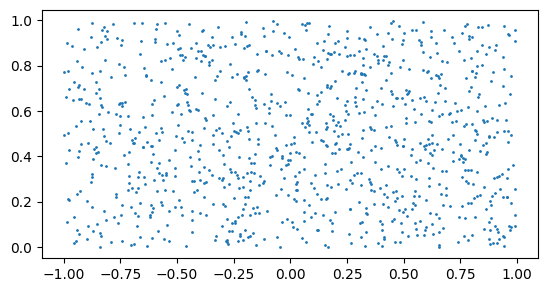

In [6]:
xmin,xmax = (-1,1)
tmin,tmax = (0,1)

domain = Rectangle((( xmin,tmin),(xmax,tmax) ),'corners')
domain = Domain2D(base = domain)
domain.Domain
sampled_points = domain.generate_points(1000)
plt.gca().set_aspect('equal')
plt.scatter(sampled_points[:,0],sampled_points[:,1],s=1)

## Generate BC

In [5]:
t0 = torch.stack( [torch.linspace(xmin,xmax,100),torch.zeros(100)],dim = -1)
x0 = torch.stack( [xmin*torch.ones(100),torch.linspace(tmin,tmax,100)],dim = -1)
x1 = torch.stack( [xmax*torch.ones(100),torch.linspace(tmin,tmax,100)],dim = -1)
u_t0 = -torch.sin(torch.pi*t0[:,0])
t0.shape

torch.Size([100, 2])

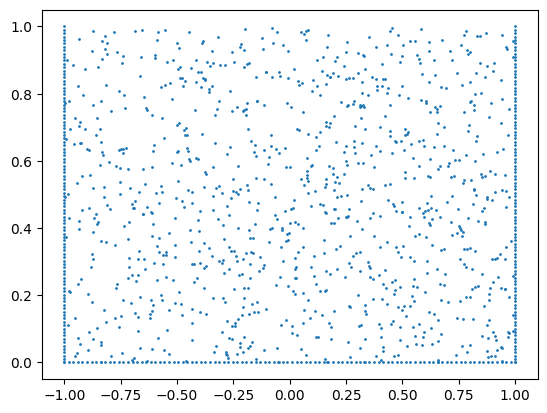

In [8]:
data = Data_handler()
data.add_group(sampled_points,'collocation points')
data.add_group(t0,'initial condition')
data.add_group(x0,'boundary_0')
data.add_group(x1,'boundary_1')

In [ ]:
torch.manual_seed(1234)
# net = DNN([2,50,50,50,50,1],'tanh')
net = MLP(2,1,50,4)
optimizer = torch.optim.Adam(params = net.parameters(), lr = 1e-3)
LR_sch = StepLR(optimizer,10000,0.9)

PINN = DE_Getter(net)
PINN.set_vars(['x','t'],['u'])
PINN.set_derivatives(['u_x','u_t','u_xx'])
PINN.set_deriv_method('AD')
net = net.cuda()
u_t0 = u_t0.cuda()

sampler = R3_sampler(domain.generate_points)

def burgers(u,u_t,u_x,u_xx,**kwargs):
    return u_t + u*u_x - (0.01/torch.pi)*u_xx


for i in range(50_000):
    # 
    data.set_to_device('cuda')
    
    output = PINN.calculate(data)

    collo = output['collocation points']
    res = burgers(**collo)

    IC_loss = (output['initial condition']['u'] - u_t0).square().mean()
    BC_loss = (output['boundary_0']['u'] - output['boundary_1']['u']).square().mean()

    res_loss = res.pow(2).mean()
    
    loss = 100*IC_loss + res_loss +100*BC_loss

    optimizer.zero_grad()
    print(f'Epoch {i} Total Loss {float(loss):.2E} Res Loss {float(res_loss):.2E} IC loss {float(IC_loss):.2E} BC Loss {float(BC_loss):.2E}' )
    
    loss.backward()
    
    optimizer.step()
    LR_sch.step()
    data['collocation points'] = sampler(sampled_points,res)
    

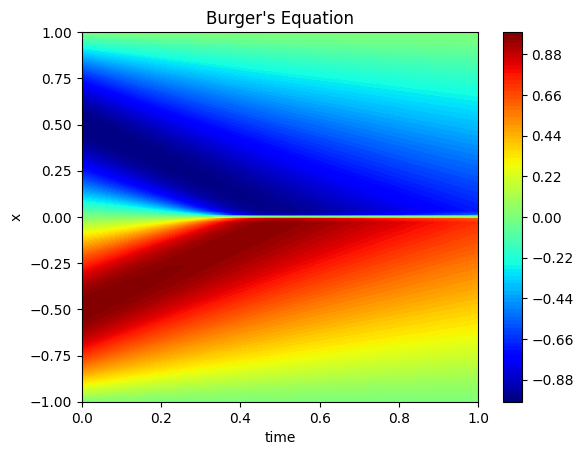

In [17]:
from matplotlib import tri
xy = torch.meshgrid(torch.linspace(xmin,xmax,100),torch.linspace(tmin,tmax,100))
x = xy[0].flatten()
y = xy[1].flatten()

tri_ang = tri.Triangulation(y, x)

net = net.cpu()
u = net(torch.stack([x,y],-1)).detach()
u.device


plt.title("Burger's Equation")
plt.tricontourf(tri_ang,u[:,0],levels =100,cmap = 'jet')
plt.colorbar()
plt.xlabel('time')
plt.ylabel('x')
plt.show()


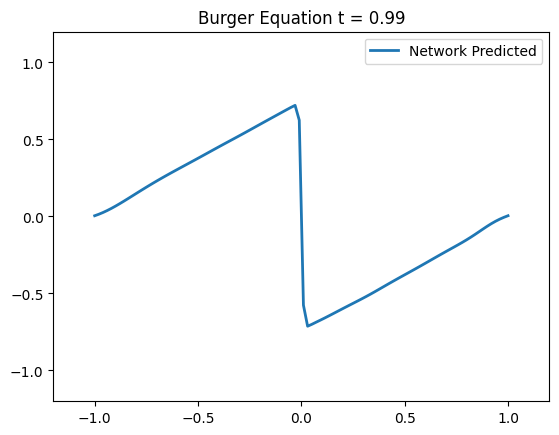

In [24]:
from matplotlib.animation import FuncAnimation
fig = plt.figure()
axis = plt.axes(xlim =(-1.2, 1.2),
				ylim =(-1.2, 1.2))

# line, = axis.plot([], [], lw = 2,label = 'True Value')
line, = axis.plot([], [], lw = 2,label = 'Network Predicted')
k=1

def init():
	line.set_data([], [])
	return line,

# initializing empty values
# for x and y co-ordinates
xdata, ydata = [], []
plt.legend()
# animation function
def animate(i):
    x = torch.linspace(-1, 1, 100)
    t = i*0.01
    
    t_net = torch.ones_like(x)*t

    points = torch.stack([x,t_net],dim = -1)
    y_pred = net(points)
    axis.set_title(f'Burger Equation t = {t:.2f}')

    # line.set_data(x,y_true)
    line.set_data(x,y_pred.detach().squeeze())
    return (line,)
	

# calling the animation function	
anim = FuncAnimation(fig, animate,
							init_func = init,
							frames = 100,
							interval = 20,
							blit = True)

# saves the animation in our desktop
anim.save('Burgers Equation.gif', writer = 'ffmpeg', fps = 10)